In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

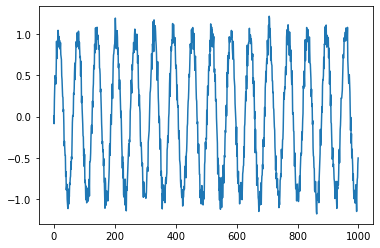

In [21]:
N = 1000
series = np.sin(0.1*np.arange(N))  + np.random.randn(N)*0.1

plt.plot(series);

In [22]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10) Y.shape (990, 1)


In [23]:
X

array([[ 0.00906591, -0.0862673 ,  0.19610934, ...,  0.39295982,
         0.58640662,  0.90853861],
       [-0.0862673 ,  0.19610934,  0.35316824, ...,  0.58640662,
         0.90853861,  0.69892273],
       [ 0.19610934,  0.35316824,  0.49373235, ...,  0.90853861,
         0.69892273,  0.80449995],
       ...,
       [-0.97448464, -0.89095955, -1.04490979, ..., -1.14643765,
        -0.86706744, -0.76181895],
       [-0.89095955, -1.04490979, -0.95272605, ..., -0.86706744,
        -0.76181895, -0.73554118],
       [-1.04490979, -0.95272605, -1.02259591, ..., -0.76181895,
        -0.73554118, -0.57115502]])

In [24]:
## Define the model - linear autoregressive
model = nn.Linear(T, 1)

In [25]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [26]:
# split data set (not random)
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [27]:
# a full GD training function, since the dataset is small 
def full_gd(model,criterion,optimizer,X_train,y_train,X_test,y_test,epochs=200):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        optimizer.zero_grad()
        #Forward pass
        outputs = model(X_train)
        loss = criterion(outputs,y_train)

        #backward pass
        loss.backward()
        optimizer.step()

        #save losses
        train_losses[it] = loss.item()
         
        test_output = model(X_test)
        test_loss = criterion(test_output,y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
            
    return train_losses, test_losses
      

In [28]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.0323, Test Loss: 0.0962
Epoch 10/200, Train Loss: 0.0537, Test Loss: 0.0736
Epoch 15/200, Train Loss: 0.0386, Test Loss: 0.0533
Epoch 20/200, Train Loss: 0.0356, Test Loss: 0.0393
Epoch 25/200, Train Loss: 0.0249, Test Loss: 0.0287
Epoch 30/200, Train Loss: 0.0241, Test Loss: 0.0245
Epoch 35/200, Train Loss: 0.0201, Test Loss: 0.0207
Epoch 40/200, Train Loss: 0.0176, Test Loss: 0.0179
Epoch 45/200, Train Loss: 0.0157, Test Loss: 0.0176
Epoch 50/200, Train Loss: 0.0148, Test Loss: 0.0173
Epoch 55/200, Train Loss: 0.0148, Test Loss: 0.0173
Epoch 60/200, Train Loss: 0.0146, Test Loss: 0.0166
Epoch 65/200, Train Loss: 0.0142, Test Loss: 0.0162
Epoch 70/200, Train Loss: 0.0139, Test Loss: 0.0161
Epoch 75/200, Train Loss: 0.0138, Test Loss: 0.0159
Epoch 80/200, Train Loss: 0.0136, Test Loss: 0.0157
Epoch 85/200, Train Loss: 0.0134, Test Loss: 0.0156
Epoch 90/200, Train Loss: 0.0133, Test Loss: 0.0155
Epoch 95/200, Train Loss: 0.0132, Test Loss: 0.0154
Epoch 100/200

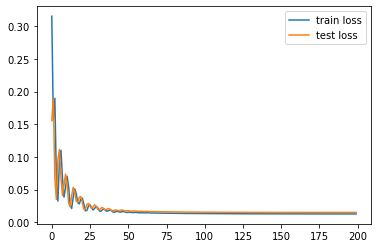

In [29]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [30]:
# Prediction - in correct way for timeserires
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0
while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1,-1)
    p = model(input_)[0,0].item()
    i = i +1

    validation_predictions.append(p)


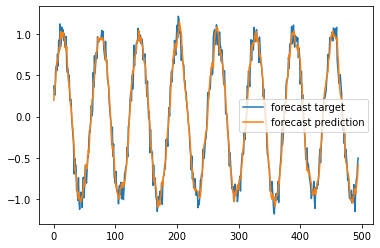

In [31]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

In [32]:
#Forecast - using self predictions
validation_target = Y[-N//2:]
validation_predictions = []

last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
    input_ = last_x.view(1,-1)
    p = model(input_)

    validation_predictions.append(p[0,0].item())

    #make new dataset
    last_x = torch.cat((last_x[1:],p[0]))

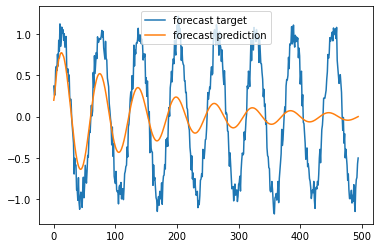

In [33]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();